# Análise da comparação entre as palavras das sentenças do CohQuAD Init pt-br

Realiza a análise da comparação entre as palavras das sentenças dos documentos do conjunto de dados utilizando o arquivo:

- `comparacao_palavra_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 162 kB 68.3 MB/s 
     |████████████████████████████████| 181 kB 59.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 158 kB 81.5 MB/s 
     |████████████████████████████████| 157 kB 78.0 MB/s 
     |████████████████████████████████| 157 kB 60.9 MB/s 
     |████████████████████████████████| 157 kB 74.9 MB/s 
     |████████████████████████████████| 157 kB 68.5 MB/s 
     |████████████████████████████████| 157 kB 74.3 MB/s 
     |████████████████████████████████| 157 kB 86.1 MB/s 
     |████████████████████████████████| 157 kB 90.3 MB/s 
     |████████████████████████████████| 156 kB 84.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b9aa85c795f2a3df7cb3c4b37ff6b5fbf7360e5f39d771615ac6e6ff1332

# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1 # Somente 1 para o Cohebert Manual

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1 # Somente 1 para o Cohebert Manual

## Específicos

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_PTBR"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação das palavras



## 3.1 Carregamento dos arquivos de dados originais e perturbados

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import de bibliotecas
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_INIT_PTBR


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
# Import de bibliotecas
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
3,4,['Como empilhar e desempilhar elementos em uma...,Como empilhar e desempilhar elementos em uma p...
9,10,['O que é uma fila e como enfileirar seu eleme...,O que é uma fila e como enfileirar seu elemento?
16,17,['Como são implementadas as operações de empil...,Como são implementadas as operações de empilha...
8,9,['O que é uma pilha e como empilhar seu elemen...,O que é uma pilha e como empilhar seu elemento?
10,11,['O que é uma fila e como desenfileirar um ele...,O que é uma fila e como desenfileirar um eleme...


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
8,9,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
0,1,"[[['Como', 'enfileirar', 'elementos', 'em', 'u..."
9,10,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
3,4,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."
4,5,"[[['Como', 'empilhar', 'elementos', 'em', 'uma..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?
4,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma p...
5,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 20.
INFO:root:TERMINADO PERTURBADOS POS: 20.


AlgUns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
10,11_pert_0,['O que é uma pilha e como desenfileirar um el...,O que é uma pilha e como desenfileirar um elem...,[['O que é uma [MASK] e como desenfileirar um ...
15,16_pert_0,['O que é uma pilha e como enfileirar e desenf...,O que é uma pilha e como enfileirar e desenfil...,[['O que é uma [MASK] e como enfileirar e dese...
18,19_pert_0,['Em uma pilha a operação de enfileirar ocorre...,Em uma pilha a operação de enfileirar ocorre e...,[['Em uma pilha a operação de [MASK] ocorre em...
12,13_pert_0,['O que é uma pilha e como enfileirar um eleme...,O que é uma pilha e como enfileirar um element...,[['O que é uma [MASK] e como enfileirar um ele...
13,14_pert_0,['O que é uma fila e como empilhar um elemento...,O que é uma fila e como empilhar um elemento n...,[['O que é uma [MASK] e como empilhar um eleme...


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
5,6_pert_0,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."
9,10_pert_0,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
0,1_pert_0,"[[['Como', 'enfileirar', 'elementos', 'em', 'u..."
11,12_pert_0,"[[['O', 'que', 'é', 'uma', 'fila', 'e', 'como'..."
3,4_pert_0,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 20.


#### Criando dados indexados perturbados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[Como enfileirar elementos em uma pilha ?],Como enfileirar elementos em uma pilha ?',"[[Como enfileirar elementos em uma [MASK] ?, f..."
2_pert_0,[Como desenfileirar elementos em uma pilha ?],Como desenfileirar elementos em uma pilha ?',[[Como desenfileirar elementos em uma [MASK] ?...
3_pert_0,[Como empilhar elementos em uma fila ?],Como empilhar elementos em uma fila ?,"[[Como empilhar elementos em uma [MASK] ?, pil..."
4_pert_0,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma f...,[[Como empilhar e desempilhar elementos em uma...
5_pert_0,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...,[[Como empilhar elementos em uma estrutura de ...


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
1_pert_0,"[[[Como, enfileirar, elementos, em, uma, pilha..."
2_pert_0,"[[[Como, desenfileirar, elementos, em, uma, pi..."
3_pert_0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
4_pert_0,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5_pert_0,"[[[Como, empilhar, elementos, em, uma, estrutu..."


### 5.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [ ]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
10,6,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma e...,1
16,9,[O que é uma pilha e como empilhar seu elemento?],O que é uma pilha e como empilhar seu elemento?,1
28,15,[O que é uma pilha e como empilhar e desempilh...,O que é uma pilha e como empilhar e desempilha...,1
22,12,[O que é uma pilha e como desempilhar um eleme...,O que é uma pilha e como desempilhar um elemen...,1
5,3_pert_0,[Como empilhar elementos em uma fila ?],Como empilhar elementos em uma fila ?,0


In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 40.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

,id,pos_documento
6,7,"[[[Como, desempilhar, elementos, em, uma, pilh..."
2,3_pert_0,"[[[Como, empilhar, elementos, em, uma, fila, ?..."
7,8_pert_0,"[[[Como, desempilhar, elementos, em, uma, estr..."
8,9_pert_0,"[[[O, que, é, uma, fila, e, como, empilhar, se..."
18,19,"[[[Em, uma, pilha, a, operação, de, empilhar, ..."


#### Criar dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?,1
1_pert_0,[Como enfileirar elementos em uma pilha ?],Como enfileirar elementos em uma pilha ?',0
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?,1
2_pert_0,[Como desenfileirar elementos em uma pilha ?],Como desenfileirar elementos em uma pilha ?',0
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?,1


In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

,pos_documento
id,
1,"[[[Como, enfileirar, elementos, em, uma, fila,..."
2,"[[[Como, desenfileirar, elementos, em, uma, fi..."
3,"[[[Como, empilhar, elementos, em, uma, pilha, ..."
4,"[[[Como, empilhar, e, desempilhar, elementos, ..."
5,"[[[Como, empilhar, elementos, em, uma, estrutu..."


## 3.2 Carregamento do arquivo de dado comparação 

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_COMPACTADO = "comparacao_palavra_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHQUAD_INIT_PTBR


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

INFO:root:Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_palavra = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_palavra)))

INFO:root:TERMINADO ORIGINAIS: 2240.


In [ ]:
lista_comparacao_palavra.sample(5)

,id,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
1111,13_pert_0,25,0,0,O,PRON,10,nela,PRON,0.493326,39.849411,1957.5186,0.493326,39.849411,1957.5186
1586,16_pert_0,31,0,5,e,CCONJ,8,e,CCONJ,0.132696,42.840542,1694.0161,0.132696,42.840542,1694.0161
365,6_pert_0,11,0,1,empilhar,VERB,2,e,CCONJ,0.747316,26.236635,1265.8730,0.647059,32.615864,1585.3103
2041,19,36,0,10,extremidade,NOUN,11,?,PUNCT,0.524961,40.380085,1898.4695,0.524961,40.380085,1898.4695
1626,17,32,0,1,são,AUX,3,as,DET,0.816481,22.966883,1136.5592,0.816481,22.966883,1136.5592


### 3.5.5 Criando dados indexados

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id", "index_sentenca", "index_wi", "index_wj"])
lista_comparacao_palavra_indexado.head()

index_documento    wi  pos_i          wj  \
id index_sentenca index_wi index_wj                                             
1  0              0        1                       0  Como  SCONJ  enfileirar   
                           2                       0  Como  SCONJ   elementos   
                           3                       0  Como  SCONJ          em   
                           4                       0  Como  SCONJ         uma   
                           5                       0  Como  SCONJ        fila   

                                    pos_j  cos_mean   euc_mean   man_mean  \
id index_sentenca index_wi index_wj                                         
1  0              0        1         VERB  0.759586  25.941952  1294.4813   
                           2         NOUN  0.607320  37.124222  1770.7854   
                           3          ADP  0.658418  33.079350  1641.0864   
                           4          DET  0.700411  29.079645  1441.1697   
                           5         NOUN  0.630520  31.865469  1558.0065   

                                      cos_max    euc_max    man_max  
id index_sentenca index_wi index_wj                                  
1  0              0        1         0.673417  31.297092  1554.1917  
                           2         0.607320  37.124222  1770.7854  
                           3         0.658418  33.079350  1641.0864  
                           4         0.700411  29.079645  1441.1697  
                           5         0.578515  35.350060  1716.5850

## 3.3 Estatísticas

### Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_palavra[["cos_mean", "euc_mean", "man_mean", "cos_max", "euc_max", "man_max" ]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,0.625612,33.349606,1592.330062,0.597097,35.283469,1687.898158
std,0.134970,5.305865,212.915325,0.135890,5.386186,225.860610
min,0.055016,6.765657,166.194550,0.055016,6.765657,166.194550
25%,0.581894,29.716749,1456.323950,0.546752,31.985140,1564.989825
50%,0.646158,33.041214,1607.303550,0.609683,35.363918,1705.955550
75%,0.701848,36.629876,1730.974200,0.673377,39.003185,1844.373125
max,0.967897,50.941257,2187.814500,0.967897,54.258480,2301.813700


### Estatísticas das maiores discrepâncias por documento

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

discrepancias  = lista_comparacao_palavra.groupby("id").agg({"cos_mean":[coluna_discrepancia_cos], 
                                                             "euc_mean":[coluna_discrepancia_euc], 
                                                             "man_mean":[coluna_discrepancia_man],
                                                             "cos_max":[coluna_discrepancia_cos], 
                                                             "euc_max":[coluna_discrepancia_euc], 
                                                             "man_max":[coluna_discrepancia_man],
                                                             })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
,min,max,max,min,max,max
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.435959,42.665833,1941.014140,0.416216,43.691093,2029.415937
std,0.183741,4.670377,146.779798,0.176697,4.761201,165.055519
min,0.055016,34.545361,1687.682600,0.055016,34.545361,1694.120400
25%,0.429877,37.564875,1800.950100,0.429877,39.720174,1920.536300
50%,0.479911,42.808325,1926.089600,0.464380,43.490297,2067.697600
75%,0.581551,46.357691,2091.888050,0.543673,47.316683,2137.978450
max,0.610777,50.941257,2187.814500,0.607332,54.258480,2301.813700


### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])

1 uma 40
2 ? 40
3 e 28
4 elementos 24
5 em 24
6 Como 20
7 fila 20
8 pilha 20
9 empilhar 18
10 O 16
11 que 16
12 é 16
13 como 16
14 desempilhar 14
15 de 14
16 enfileirar 12
17 elemento 12
18 desenfileirar 8
19 um 8
20 nela 8


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### COS

In [ ]:
medida = "cos"

#### MEAN

In [ ]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,182.000000,0.686815,0.067159,0.556238,0.632577,0.678821,0.740695,0.860071
ADV,129.000000,0.632809,0.137036,0.103438,0.566416,0.655477,0.721156,0.825127
AUX,192.000000,0.597350,0.127507,0.064609,0.566327,0.620957,0.667436,0.829288
CCONJ,166.000000,0.513329,0.244398,0.101886,0.196683,0.593457,0.703709,0.967897
DET,354.000000,0.656119,0.101545,0.134931,0.626358,0.658835,0.709517,0.842426
NOUN,434.000000,0.627535,0.091207,0.132799,0.586065,0.636978,0.686145,0.808674
PRON,346.000000,0.597120,0.136042,0.055016,0.514167,0.586691,0.695712,0.816210
SCONJ,165.000000,0.638455,0.118557,0.096426,0.595003,0.648913,0.716400,0.810075
VERB,272.000000,0.655403,0.133910,0.104145,0.616287,0.678951,0.714116,0.906370


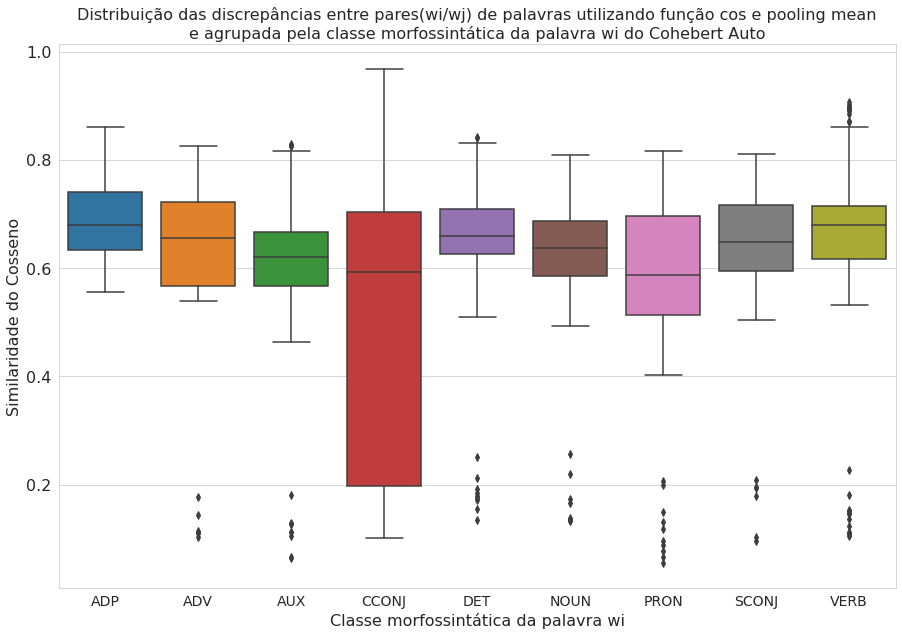

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,168.000000,0.671962,0.109990,0.101886,0.638890,0.680974,0.730162,0.842426
ADV,110.000000,0.650023,0.109704,0.133869,0.627019,0.656862,0.702531,0.901491
AUX,36.000000,0.730151,0.039799,0.666537,0.696768,0.732807,0.754851,0.807496
CCONJ,148.000000,0.436499,0.265759,0.055016,0.147632,0.564841,0.660748,0.967897
DET,371.000000,0.646118,0.116442,0.119810,0.594299,0.653818,0.711726,0.897620
NOUN,642.000000,0.612183,0.110480,0.127351,0.551830,0.627783,0.689506,0.872450
PRON,105.000000,0.614188,0.090529,0.425773,0.546080,0.623427,0.676601,0.770674
PUNCT,394.000000,0.642805,0.107131,0.127486,0.591160,0.632219,0.691832,0.827132
SCONJ,58.000000,0.670726,0.065119,0.521147,0.642058,0.658811,0.713171,0.794104


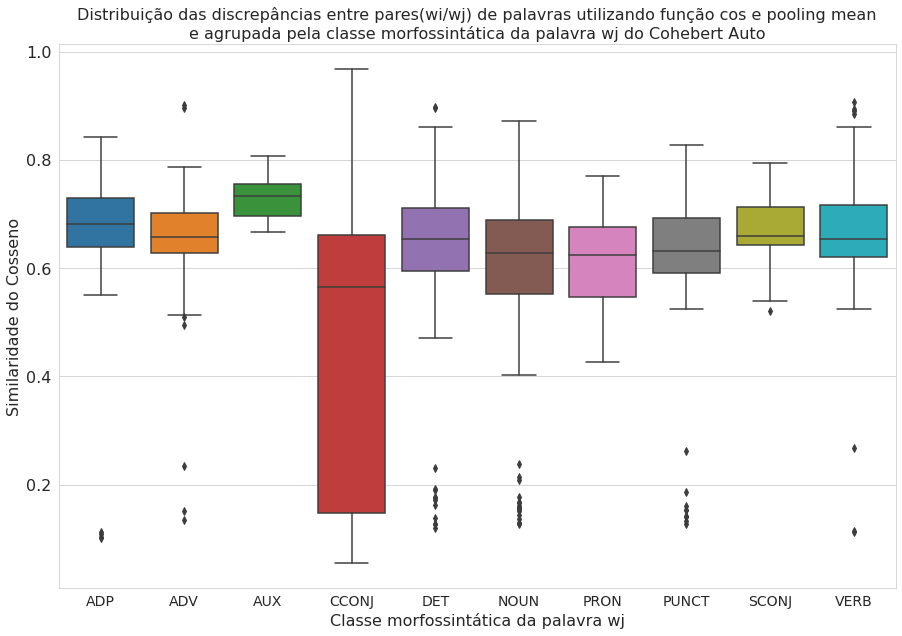

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

#### MAX

In [ ]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,182.000000,0.676322,0.071405,0.506135,0.619798,0.671052,0.726838,0.860071
ADV,129.000000,0.595832,0.137219,0.103438,0.552132,0.593690,0.663091,0.825127
AUX,192.000000,0.579629,0.131272,0.064609,0.526475,0.600267,0.665127,0.829288
CCONJ,166.000000,0.495536,0.242257,0.078584,0.190537,0.561199,0.681561,0.967897
DET,354.000000,0.637199,0.107482,0.134931,0.600020,0.649444,0.688805,0.842426
NOUN,434.000000,0.598143,0.091321,0.119198,0.554061,0.598799,0.650941,0.783259
PRON,346.000000,0.585456,0.140241,0.055016,0.496159,0.576792,0.695712,0.816210
SCONJ,165.000000,0.612641,0.115730,0.096426,0.571979,0.618047,0.663825,0.810075
VERB,272.000000,0.570519,0.130349,0.082438,0.522736,0.575105,0.634642,0.888144


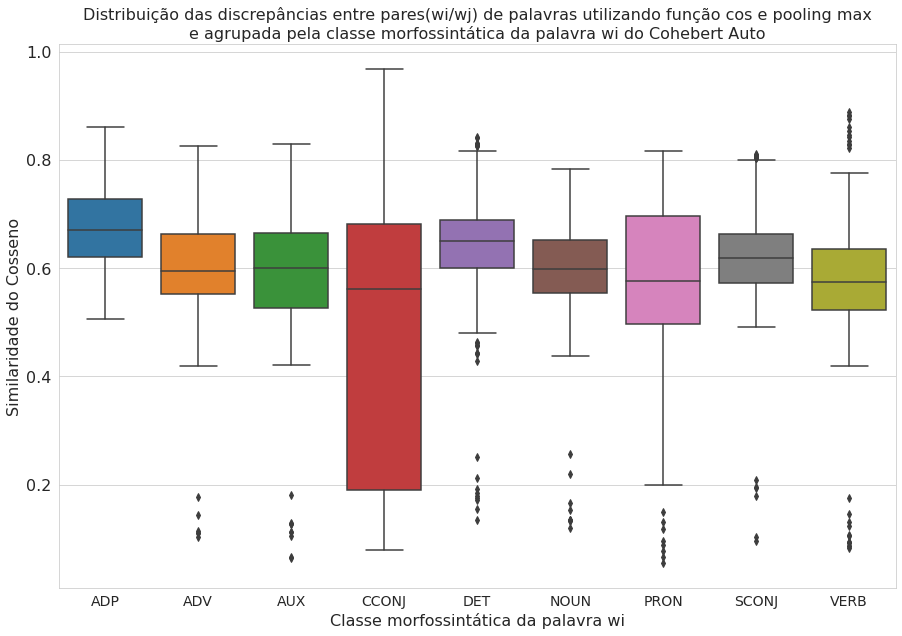

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,168.000000,0.639528,0.110821,0.101886,0.594923,0.646278,0.691991,0.842426
ADV,110.000000,0.617920,0.128856,0.086097,0.536096,0.643425,0.683275,0.888144
AUX,36.000000,0.730151,0.039799,0.666537,0.696768,0.732807,0.754851,0.807496
CCONJ,148.000000,0.428886,0.265202,0.055016,0.135014,0.533982,0.655028,0.967897
DET,371.000000,0.623064,0.119048,0.083782,0.570760,0.633196,0.684903,0.881570
NOUN,642.000000,0.581613,0.108234,0.110994,0.522895,0.581149,0.657087,0.834225
PRON,105.000000,0.600490,0.089588,0.425773,0.540385,0.603622,0.652685,0.770674
PUNCT,394.000000,0.625780,0.113008,0.127486,0.574628,0.611720,0.677241,0.827132
SCONJ,58.000000,0.665656,0.071056,0.519028,0.638787,0.657850,0.713171,0.794104


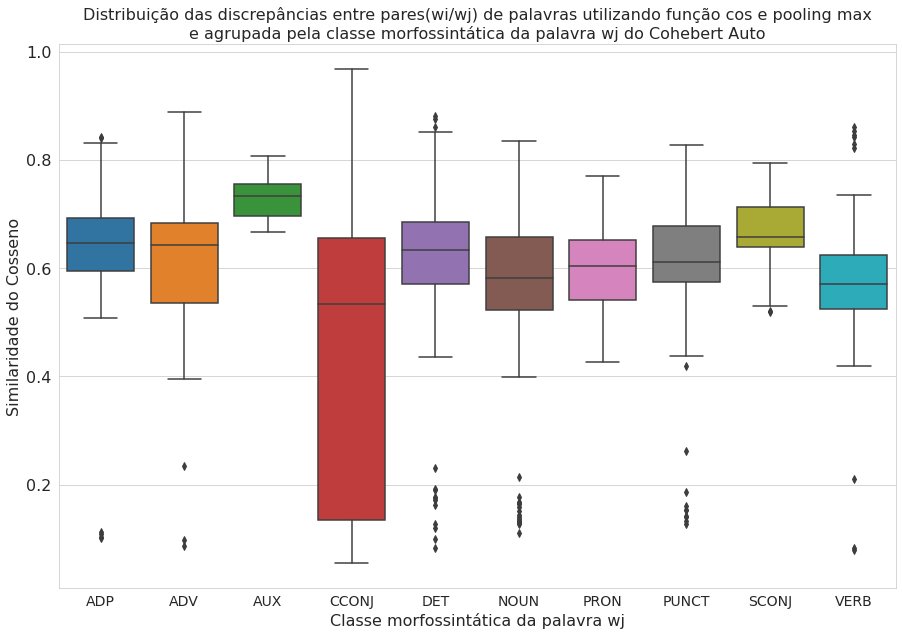

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

# Mostra o gráfico
plt.show()

### EUC

In [ ]:
medida = "euc"

#### MEAN

In [ ]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,182.000000,31.982066,4.517441,21.245766,28.439395,32.243290,34.754243,48.045490
ADV,129.000000,32.901896,5.257158,22.694429,28.881088,32.391834,36.757378,44.029022
AUX,192.000000,34.523726,4.530371,22.114536,31.779044,33.524361,36.919543,47.151665
CCONJ,166.000000,35.026635,7.314374,6.765657,29.381985,34.953388,40.776598,50.941257
DET,354.000000,31.967313,4.401458,22.434294,29.355294,31.897808,33.969774,44.619400
NOUN,434.000000,34.449283,4.233048,23.230267,31.807874,34.453205,37.071498,47.091286
PRON,346.000000,34.603528,5.880697,23.157562,30.071871,35.058355,38.823238,50.019108
SCONJ,165.000000,32.809792,5.180620,23.407797,28.807222,32.770618,35.884304,47.889687
VERB,272.000000,31.401494,5.500904,15.100810,28.695445,31.230951,34.757515,47.674778


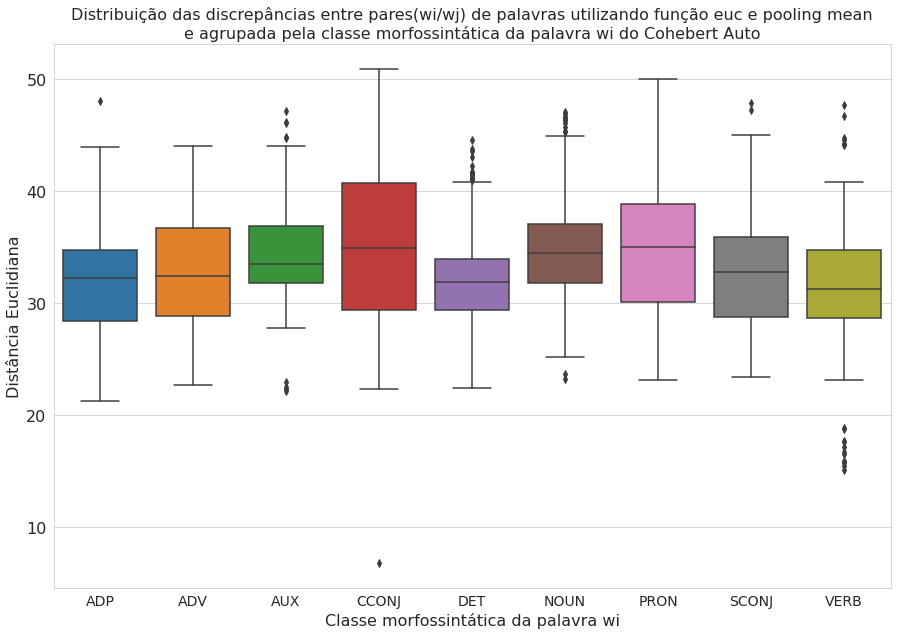

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,168.000000,31.947861,4.256307,22.434294,29.136453,32.180742,34.325757,46.196293
ADV,110.000000,31.797105,4.198684,15.401643,29.392066,32.448763,33.820061,42.460812
AUX,36.000000,28.851350,2.150067,23.572884,28.232870,29.217420,30.412475,31.870003
CCONJ,148.000000,36.208169,6.959188,6.765657,31.467446,36.334028,42.337812,46.412331
DET,371.000000,31.988790,4.694427,15.669219,28.937135,32.077198,35.173887,43.919960
NOUN,642.000000,35.412383,5.361494,17.615896,31.555700,34.884907,39.327461,50.941257
PRON,105.000000,35.272068,4.529040,26.598030,31.906261,35.434658,38.393127,44.367363
PUNCT,394.000000,32.488219,4.883597,22.340097,29.317446,33.021517,35.594569,46.882282
SCONJ,58.000000,31.667815,3.617450,24.415045,29.346995,32.089060,34.177338,39.882729


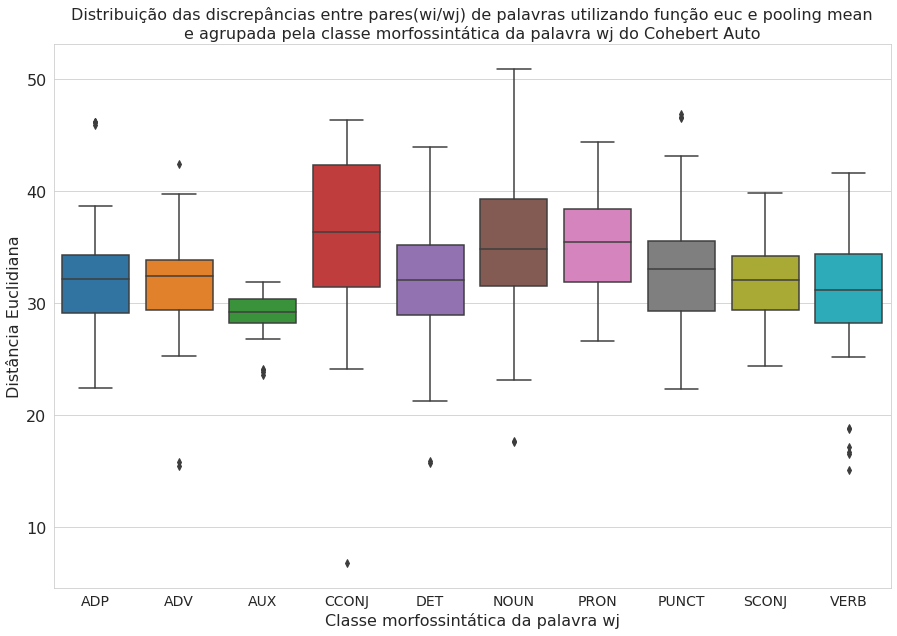

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAX

In [ ]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,182.000000,32.637295,4.574980,21.245766,29.425520,32.725819,35.337685,48.045490
ADV,129.000000,35.344859,5.514176,22.694429,32.066177,35.899101,39.430050,44.043137
AUX,192.000000,35.743350,4.895268,22.114536,32.368687,35.292450,39.329300,47.151665
CCONJ,166.000000,36.509702,7.519126,6.765657,31.133672,37.162045,42.266998,50.941257
DET,354.000000,33.237674,4.722085,22.434294,30.543372,32.658379,35.998732,44.619400
NOUN,434.000000,36.391235,3.805325,26.107985,34.255722,36.391645,38.466956,52.351444
PRON,346.000000,35.442739,6.208562,23.157562,30.465203,36.115755,40.119146,50.019108
SCONJ,165.000000,34.485980,4.930076,23.407797,32.101902,34.244572,38.095745,47.889687
VERB,272.000000,37.128141,5.199034,20.385046,34.598607,37.737331,39.966434,54.258480


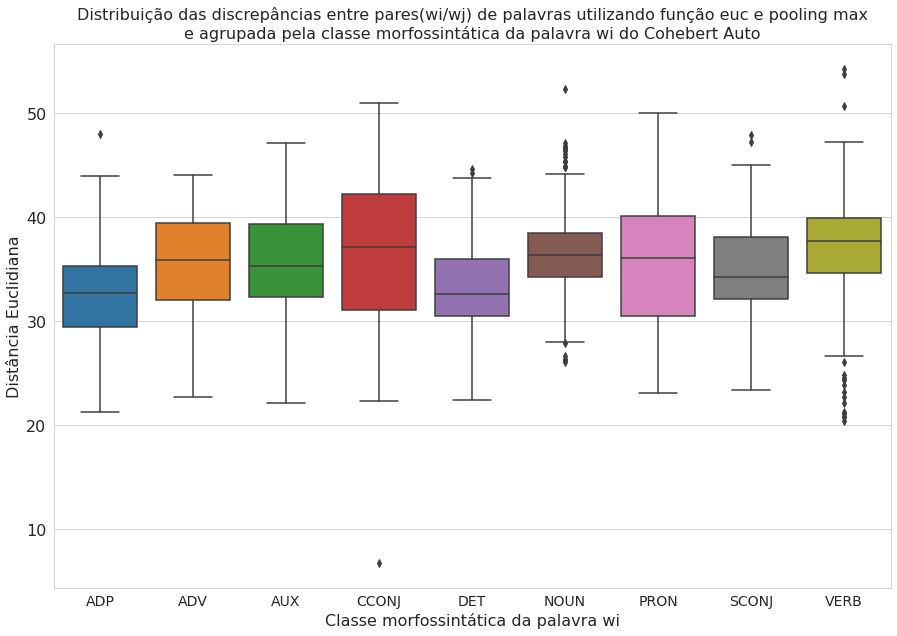

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,168.000000,33.923638,4.338335,22.434294,31.988555,33.851101,36.259918,46.196293
ADV,110.000000,34.284964,5.678158,20.385046,31.025487,33.322098,38.164710,48.277248
AUX,36.000000,28.851350,2.150067,23.572884,28.232870,29.217420,30.412475,31.870003
CCONJ,148.000000,36.945069,7.112015,6.765657,31.607265,37.102369,43.395051,47.232845
DET,371.000000,33.572521,4.914815,20.830475,30.853283,33.617283,36.801884,48.315918
NOUN,642.000000,37.444903,4.940774,23.921432,34.165078,37.916729,40.662619,54.258480
PRON,105.000000,36.090594,4.473277,26.598030,34.180439,36.932518,39.158195,44.367363
PUNCT,394.000000,33.602367,5.220237,22.340097,31.489161,34.465263,36.899315,46.882282
SCONJ,58.000000,32.020256,3.947338,24.415045,29.346995,32.318388,34.382958,39.882729


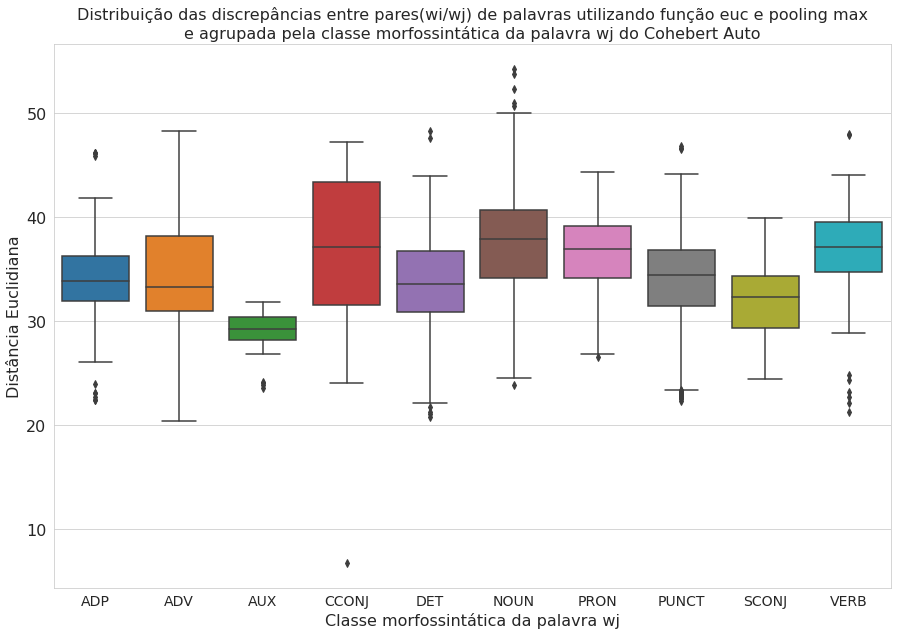

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

### MAN

In [ ]:
medida = "man"

#### MEAN

In [ ]:
estrategia_pooling = "mean"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,182.000000,1537.770788,193.362917,1040.423300,1401.054000,1565.939000,1660.054025,1954.044900
ADV,129.000000,1601.910985,215.121773,1114.010600,1453.969700,1606.182700,1745.322000,1973.384600
AUX,192.000000,1651.419139,162.427071,1099.821800,1558.207425,1642.135000,1760.682725,2055.090800
CCONJ,166.000000,1571.117661,234.582232,166.194550,1442.081600,1610.337200,1713.660700,1969.483000
DET,354.000000,1542.911047,178.239047,1115.934600,1408.350225,1571.311900,1665.119725,1963.912800
NOUN,434.000000,1623.195585,160.160414,1134.934800,1512.674725,1639.222050,1740.981475,1955.239000
PRON,346.000000,1681.362827,260.781215,1129.189200,1472.858625,1728.537800,1872.502075,2187.814500
SCONJ,165.000000,1594.251988,206.939812,1154.737800,1432.467800,1627.421800,1725.573000,1983.691200
VERB,272.000000,1496.176547,227.685699,729.162960,1393.371225,1499.475550,1649.433650,1914.375500


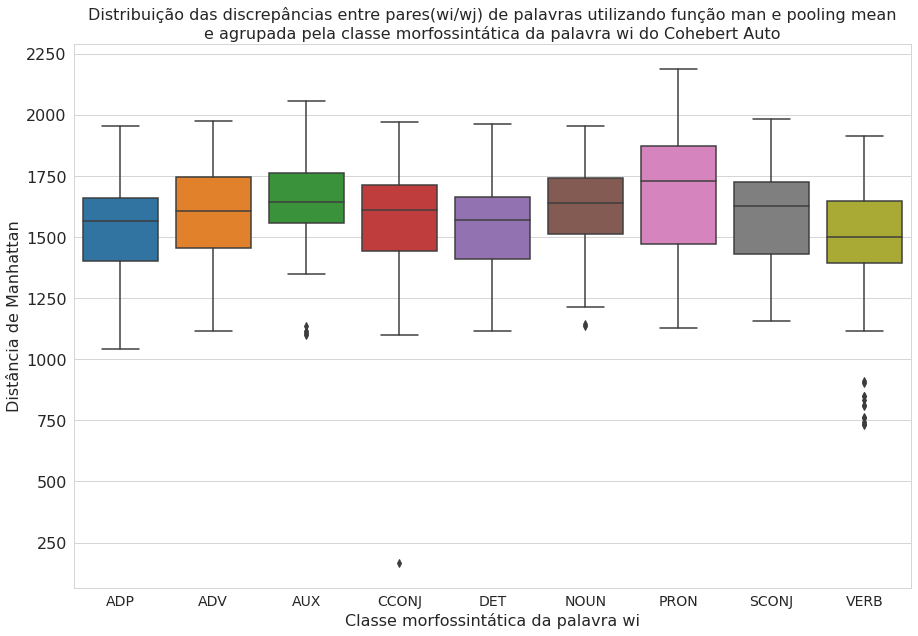

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,168.000000,1553.599916,172.255374,1128.555900,1416.656725,1574.927100,1676.061700,1853.505900
ADV,110.000000,1546.217851,193.146266,737.115970,1433.152400,1598.301750,1664.266850,1895.894800
AUX,36.000000,1418.518733,101.777185,1168.542000,1390.996125,1433.308850,1485.658575,1566.615000
CCONJ,148.000000,1598.352232,220.550704,166.194550,1521.715625,1646.898250,1722.156775,2028.651700
DET,371.000000,1559.407191,214.000199,744.366640,1431.553650,1590.072900,1714.155750,2029.683700
NOUN,642.000000,1647.370628,212.480341,848.396240,1498.982200,1641.393650,1814.531025,2187.814500
PRON,105.000000,1728.733132,211.405789,1325.456700,1573.438400,1739.172600,1882.450400,2125.628000
PUNCT,394.000000,1587.715688,208.587371,1101.226000,1472.574550,1640.101000,1727.144300,1914.375500
SCONJ,58.000000,1546.255928,165.575848,1205.528900,1445.680300,1556.990950,1667.186325,1904.801000


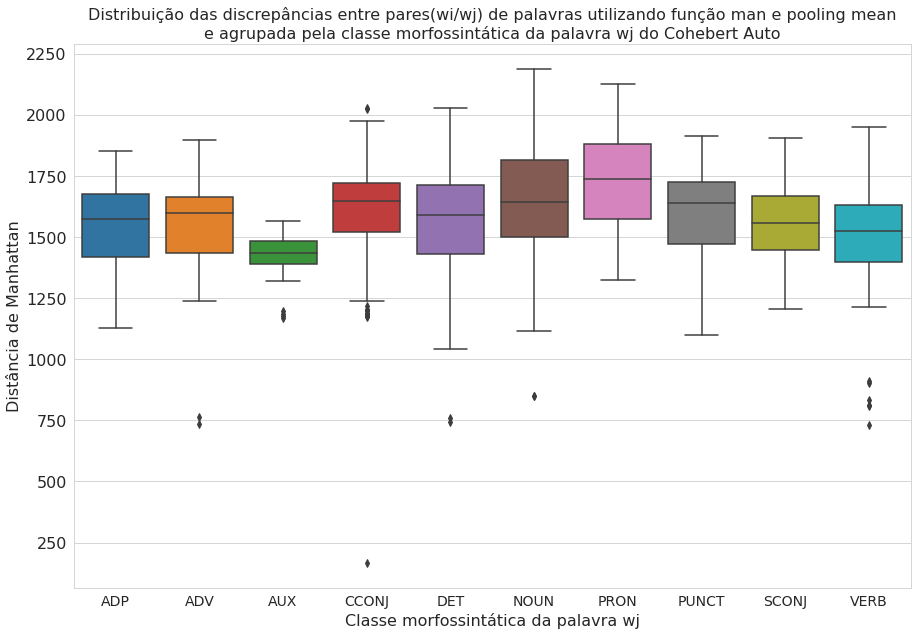

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

#### MAX

In [ ]:
estrategia_pooling = "max"
coluna_equacao = medida + "_" + estrategia_pooling

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})
#lista.describe().rename(columns={"count": "#","mean": "avg"}).transpose()

,#,avg,std,min,25%,50%,75%,max
pos_i,,,,,,,,
ADP,182.000000,1570.029729,200.171915,1040.423300,1431.594650,1590.384400,1725.365500,1975.189500
ADV,129.000000,1721.953229,244.472082,1114.010600,1606.182700,1740.385500,1892.936500,2209.429400
AUX,192.000000,1714.301136,195.607389,1099.821800,1586.991225,1715.247200,1846.400400,2163.517300
CCONJ,166.000000,1657.523417,261.768675,166.194550,1542.958125,1694.175300,1856.015825,2100.799000
DET,354.000000,1605.160577,203.698465,1115.934600,1488.177275,1619.420200,1710.084700,2149.620600
NOUN,434.000000,1718.587870,152.818208,1278.868400,1622.396625,1731.968350,1817.791325,2166.371000
PRON,346.000000,1724.600450,282.597280,1129.189200,1490.599100,1776.739400,1944.214675,2301.813700
SCONJ,165.000000,1674.005325,206.099262,1154.737800,1600.913100,1683.608900,1795.473500,2073.053000
VERB,272.000000,1770.967564,221.131923,949.523700,1678.996675,1811.360850,1911.661400,2215.640100


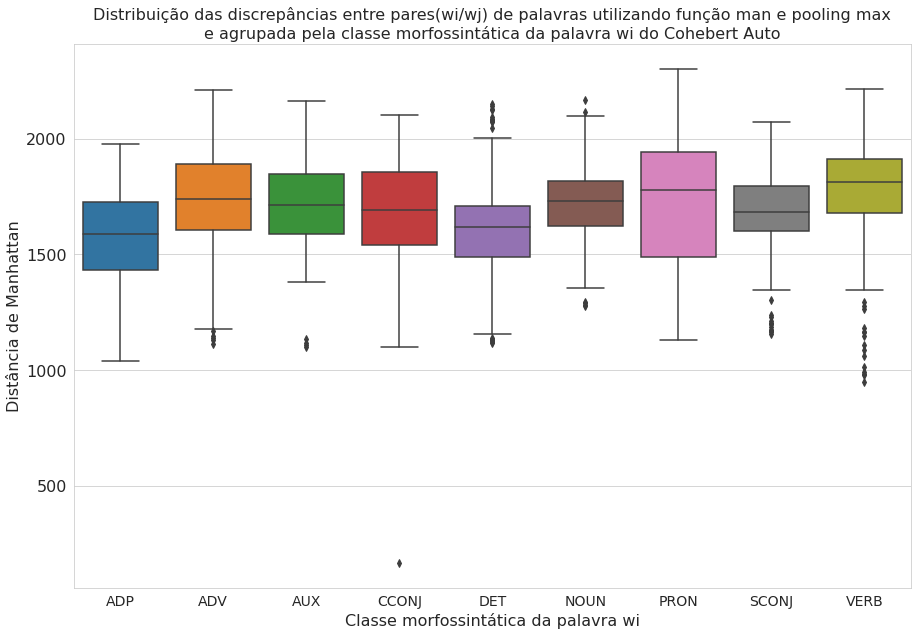

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wi do Cohebert Auto")

# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

,#,avg,std,min,25%,50%,75%,max
pos_j,,,,,,,,
ADP,168.000000,1645.121819,181.275782,1128.555900,1569.554875,1667.192200,1757.139900,2029.712900
ADV,110.000000,1674.854930,263.765033,949.523700,1517.451700,1653.825800,1863.388625,2301.813700
AUX,36.000000,1418.518733,101.777185,1168.542000,1390.996125,1433.308850,1485.658575,1566.615000
CCONJ,148.000000,1641.361529,224.394042,166.194550,1562.175225,1681.559450,1776.983050,2028.651700
DET,371.000000,1636.960527,226.483728,981.509300,1520.739800,1651.645600,1766.208850,2167.356400
NOUN,642.000000,1749.272962,203.047809,1147.120700,1611.678700,1771.049600,1896.587100,2287.402300
PRON,105.000000,1766.943550,210.459748,1325.456700,1651.303000,1792.106200,1919.892000,2125.628000
PUNCT,394.000000,1641.224770,235.099507,1101.226000,1561.332625,1686.538700,1802.207700,2215.640100
SCONJ,58.000000,1564.243140,184.536680,1205.528900,1445.680300,1589.272350,1676.307800,1924.080300


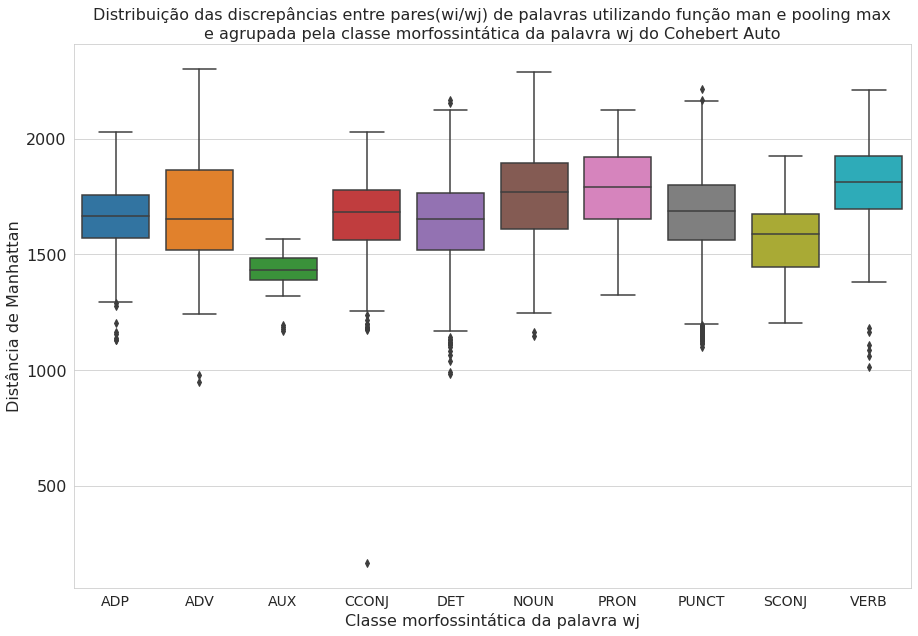

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_palavra.groupby(by=["pos_j"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_j", y = coluna_equacao, data = lista_comparacao_palavra, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre pares(wi/wj) de palavras utilizando função " + medida + " e pooling " + estrategia_pooling + "\ne agrupada pela classe morfossintática da palavra wj do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias de determinados pares de palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_palavra.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_palavra))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao["pos_i"]+"/"+linha_comparacao["pos_j"]] += 1

Documentos:   0%|          | 0/2240 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

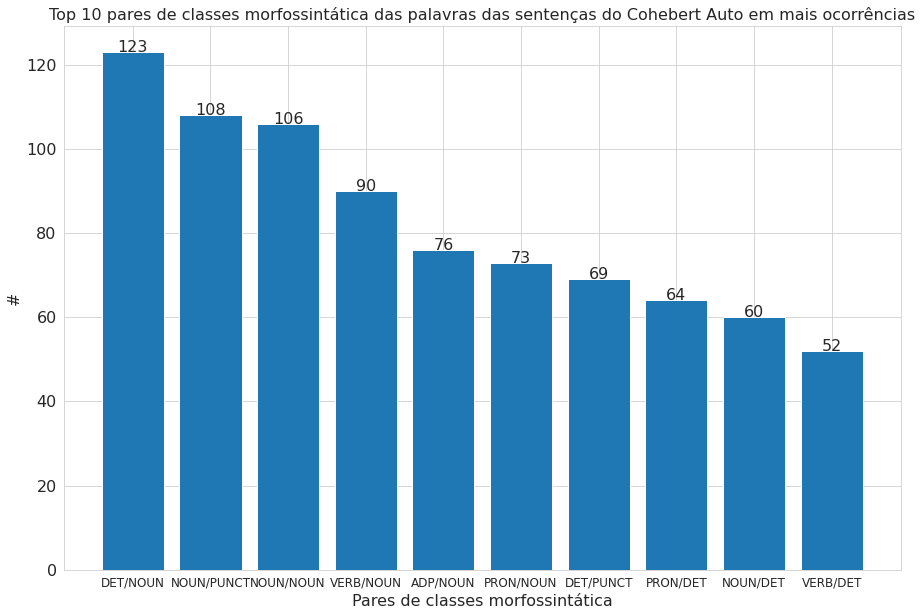

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### VERB-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 16


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.717740,27.834528,1336.068399,0.665334,33.370359,1586.052456
std,0.132064,8.689005,408.509942,0.146011,8.582836,401.925308
min,0.601869,15.100810,729.162960,0.499518,21.262541,1015.052700
25%,0.618944,18.348279,884.734590,0.561718,24.071880,1151.454325
50%,0.629662,32.585564,1573.795550,0.601907,36.773935,1739.592350
75%,0.866321,34.201131,1644.281225,0.832072,39.625017,1899.603600
max,0.906370,36.627090,1741.616300,0.860713,43.756317,2065.714800


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/16 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1      empilhar    8
      2 implementadas    6
      3    enfileirar    2


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/16 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1 desempilhar    8
      2      ocorre    4
      3    empilhar    2
      4  enfileirar    2


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.2473767101764679
Limite superior             : 1.2373860627412796
Limite inferior             : 0.24787922203540802


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 16 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 16 ( 0.0 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 16 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 15.852851390838623
Limite superior             : 57.98040795326233
Limite inferior             : -5.430997610092163


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 16 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 16 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 16 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 759.5466349999999
Limite superior             : 2783.6011774999997
Limite inferior             : -254.58536249999997


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 16 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 16 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 16 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

### NOUN-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 106


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.671587,34.073814,1560.736746,0.637291,36.281486,1675.719892
std,0.040929,4.699264,132.027556,0.061249,4.769467,163.627342
min,0.566290,23.661400,1134.934800,0.472500,26.697304,1280.328400
25%,0.644958,31.360667,1473.984000,0.599890,33.072862,1538.296525
50%,0.672955,33.363808,1540.791250,0.641526,36.067902,1709.146750
75%,0.699882,35.736831,1671.023925,0.689506,38.785151,1783.058575
max,0.781816,47.091286,1861.107300,0.769884,52.351444,2058.309800


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/106 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wi
      1   elementos   32
      2 desempilhar   16
      3       pilha   14
      4        fila   14
      5   estrutura   12
      6   operações    8
      7       dados    6
      8    operação    4


Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/106 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1        fila   20
      2       pilha   20
      3       dados   14
      4   elementos   14
      5    elemento   14
      6   estrutura    8
      7 extremidade    8
      8 desempilhar    4
      9    operação    4


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.054924845695495605
Limite superior             : 0.7822697013616562
Limite inferior             : 0.5625703185796738


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 106 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 106 ( 0.0 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 106 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.376163482666016
Limite superior             : 42.30107593536377
Limite inferior             : 24.796422004699707


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 10


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 106 ( 0.009433962264150943 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  11 de 106 ( 0.10377358490566038 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 47.091285705566406 dados pilha
         Como desempilhar elementos em uma estrutura de dados pilha? 1

 2 46.66834259033203 elementos pilha
         Como empilhar elementos em uma estrutura de dados pilha? 1

 3 46.40306854248047 elementos pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1

 4 46.38642883300781 desempilhar pilha
         Como desempilhar elementos em uma estrutura de dados pilha? 1

 5 46.08236312866211 dados pilha
         Como empilhar elementos em uma estrutura de dados pilha? 1


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 23.661399841308597 desempilhar fila
         Como desempilhar elementos em uma fila ? 0


#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 197.03992500000004
Limite superior             : 1966.5838125
Limite inferior             : 1178.4241124999999


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 106 ( 0.009433962264150943 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 106 ( 0.009433962264150943 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]] 
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"] 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 1134.9348 desempilhar fila
         Como desempilhar elementos em uma fila ? 0


### NOUN-VERB

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "NOUN") & (lista_comparacao_palavra["pos_j"] == "VERB")]

lista_comparacao_classesNV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 34


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.667642,31.827191,1512.432874,0.589668,37.084109,1756.471532
std,0.052272,4.103805,189.933855,0.095710,4.728499,210.581771
min,0.580587,25.232309,1214.173800,0.440595,28.874935,1381.870400
25%,0.625104,28.993565,1344.560325,0.517785,34.553679,1691.598900
50%,0.671995,32.325972,1530.428550,0.554199,38.788565,1815.250400
75%,0.702377,34.510322,1661.190575,0.683866,40.719117,1912.400600
max,0.755604,39.462299,1840.356900,0.734969,43.644230,2116.773000


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/34 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque   palavra  #wi
      1     pilha   10
      2      fila   10
      3  operação    8
      4 operações    6


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo VERB

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/34 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1    empilhar   12
      2  enfileirar   12
      3      ocorre    8
      4 desempilhar    2


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07727377116680145
Limite superior             : 0.8182879462838173
Limite inferior             : 0.5091928616166115


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 34 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 34 ( 0.0 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 34 ( 0.0 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.516757011413574
Limite superior             : 42.785457134246826
Limite inferior             : 20.71842908859253


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 34 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 34 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 34 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 316.63024999999993
Limite superior             : 2136.13595
Limite inferior             : 869.6149500000002


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 34 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)


In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 34 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 34 ( 0.0 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe NOUN e VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

Top 5 documentos com as maiores similaridades (man(wi,wj) < limite_superior) entre palavras da classe NOUN e VERB


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1

### VERB-NOUN

#### Estatísticas

Filtrar comparação verbos com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_palavra[(lista_comparacao_palavra["pos_i"] == "VERB") & (lista_comparacao_palavra["pos_j"] == "NOUN")]

lista_comparacao_classesVN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 90


Estatísticas das medidas dos pares de palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_mean", "euc_mean","man_mean"]].describe(include=["float", "int"]) 

,cos_mean,euc_mean,man_mean
count,90.000000,90.000000,90.000000
mean,0.672871,32.309340,1510.593460
std,0.064315,5.128457,204.732509
min,0.531636,17.615896,848.396240
25%,0.634918,29.683391,1411.456275
50%,0.678951,31.907059,1519.587600
75%,0.705114,34.684297,1619.585175
max,0.872450,47.674778,1884.903900


#### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wi"]] += 1

Documentos:   0%|          | 0/90 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque       palavra  #wi
      1      empilhar   38
      2    enfileirar   16
      3   desempilhar   16
      4 implementadas   12
      5 desenfileirar    4
      6        ocorre    4


Top 20 palavras(wj) em mais ocorrências nas comparações de pos(wi) do tipo VERB e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao["wj"]] += 1

Documentos:   0%|          | 0/90 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])     

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wj"))

# Motra o rank
print(df1.to_string(index=False))

 ranque     palavra  #wj
      1   elementos   30
      2        fila   13
      3       pilha   13
      4    elemento    8
      5 extremidade    8
      6   estrutura    6
      7       dados    6
      8   operações    4
      9 desempilhar    2


#### COS

In [ ]:
medida = "cos_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07019591331481934
Limite superior             : 0.8104073852300644
Limite inferior             : 0.529623731970787


Encontra os documentos com as maiores discrepâncias (cos(wi,wj) < limite_inferior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

  print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 90 ( 0.0 )


Encontra os documentos com as maiores similaridades (cos(wi,wj) > limite_superior)

In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

  print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 2 de 90 ( 0.022222222222222223 )


In [ ]:
if len(lista_comparacao_classes[medida]) != 0:
  totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
  print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 90 ( 0.022222222222222223 )


Top 5 documentos com as maiores similaridades (cos(wi,wj) > limite_superior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
 
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1


 1 0.8724501132965088 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ? 0

 2 0.8698990345001221 empilhar desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos? 1


Top 5 documentos com as maiores similaridades (cos(wi,wj) < limite_inferior) entre palavras da classe VERB

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

#### EUC

In [ ]:
medida = "euc_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.000905513763428
Limite superior             : 42.18565487861633
Limite inferior             : 22.182032823562622


Encontra os documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 3 de 90 ( 0.03333333333333333 )


Encontra os documentos com as maiores similaridades (euc(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 90 ( 0.022222222222222223 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 90 ( 0.05555555555555555 )


Top 5 documentos com as maiores discrepâncias (euc(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 47.67477798461914 desempilhar pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1

 2 46.76974105834961 empilhar pilha
         Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1

 3 44.773216247558594 empilhar pilha
         Como empilhar elementos em uma estrutura de dados pilha? 1


Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"]) 
          cont = cont + 1


 1 17.615896224975586 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ? 0

 2 17.706588745117188 empilhar desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos? 1


#### MAN

In [ ]:
medida = "man_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 208.12889999999993
Limite superior             : 1931.7785249999997
Limite inferior             : 1099.262925


Encontra os documentos com as maiores discrepâncias (man(wi,wj) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 90 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 90 ( 0.022222222222222223 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 90 ( 0.022222222222222223 )


Top 5 documentos com as maiores discrepâncias (man(wi,wj) > limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])        
          cont = cont + 1

Top 5 documentos com as maiores similaridades (euc(wi,wj) < limite_superior) entre palavras da classe VERB e NOUN

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("\n", (cont+1), linha[medida], linha["wi"], linha["wj"])   
    # Recupera as sentenças do documento    
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca, documento["classe"])
          cont = cont + 1


 1 848.39624 empilhar desempilhar
         O que é uma pilha e como empilhar e desempilhar seus elementos? 1

 2 849.93396 empilhar desempilhar
         O que é uma fila e como empilhar e desempilhar seus elementos ? 0


### Comparando discrepância entre pares de palavras de determinadas classes

#### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean","euc_mean","man_mean","cos_max","euc_max","man_max"]].dropna()
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                              \
         cos_mean    euc_mean    man_mean     cos_max     euc_max     man_max   
count 2240.000000 2240.000000 2240.000000 2240.000000 2240.000000 2240.000000   
mean     0.625612   33.349606 1592.330062    0.597097   35.283469 1687.898158   
std      0.134970    5.305865  212.915325    0.135890    5.386186  225.860610   
min      0.055016    6.765657  166.194550    0.055016    6.765657  166.194550   
25%      0.581894   29.716749 1456.323950    0.546752   31.985140 1564.989825   
50%      0.646158   33.041214 1607.303550    0.609683   35.363918 1705.955550   
75%      0.701848   36.629876 1730.974200    0.673377   39.003185 1844.373125   
max      0.967897   50.941257 2187.814500    0.967897   54.258480 2301.813700   

      VERB-VERB                                  ...   NOUN-VERB            \
       cos_mean  euc_mean    man_mean   cos_max  ...    man_mean   cos_max   
count 16.000000 16.000000   16.000000 16.000000  ...   34.000000 34.000000   
mean   0.717740 27.834528 1336.068399  0.665334  ... 1512.432874  0.589668   
std    0.132064  8.689005  408.509942  0.146011  ...  189.933855  0.095710   
min    0.601869 15.100810  729.162960  0.499518  ... 1214.173800  0.440595   
25%    0.618944 18.348279  884.734590  0.561718  ... 1344.560325  0.517785   
50%    0.629662 32.585564 1573.795550  0.601907  ... 1530.428550  0.554199   
75%    0.866321 34.201131 1644.281225  0.832072  ... 1661.190575  0.683866   
max    0.906370 36.627090 1741.616300  0.860713  ... 1840.356900  0.734969   

                            VERB-NOUN                                  \
        euc_max     man_max  cos_mean  euc_mean    man_mean   cos_max   
count 34.000000   34.000000 90.000000 90.000000   90.000000 90.000000   
mean  37.084109 1756.471532  0.672871 32.309340 1510.593460  0.583953   
std    4.728499  210.581771  0.064315  5.128457  204.732509  0.083544   
min   28.874935 1381.870400  0.531636 17.615896  848.396240  0.463872   
25%   34.553679 1691.598900  0.634918 29.683391 1411.456275  0.518555   
50%   38.788565 1815.250400  0.678951 31.907059 1519.587600  0.569947   
75%   40.719117 1912.400600  0.705114 34.684297 1619.585175  0.632917   
max   43.644230 2116.773000  0.872450 47.674778 1884.903900  0.834225   

                             
        euc_max     man_max  
count 90.000000   90.000000  
mean  38.012617 1782.986500  
std    5.326789  211.232284  
min   23.921432 1147.120700  
25%   35.488886 1674.983975  
50%   38.474045 1820.109200  
75%   41.220898 1938.649950  
max   54.258480 2136.885000  

[8 rows x 30 columns]

#### COS

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["cos_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_mean"]].dropna(),
                    lista_comparacao_classesNV[["cos_mean"]].dropna(),
                    lista_comparacao_classesVN[["cos_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,cos_mean,cos_mean,cos_mean,cos_mean,cos_mean
count,2240.000000,16.000000,106.000000,34.000000,90.000000
mean,0.625612,0.717740,0.671587,0.667642,0.672871
std,0.134970,0.132064,0.040929,0.052272,0.064315
min,0.055016,0.601869,0.566290,0.580587,0.531636
25%,0.581894,0.618944,0.644958,0.625104,0.634918
50%,0.646158,0.629662,0.672955,0.671995,0.678951
75%,0.701848,0.866321,0.699882,0.702377,0.705114
max,0.967897,0.906370,0.781816,0.755604,0.872450


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


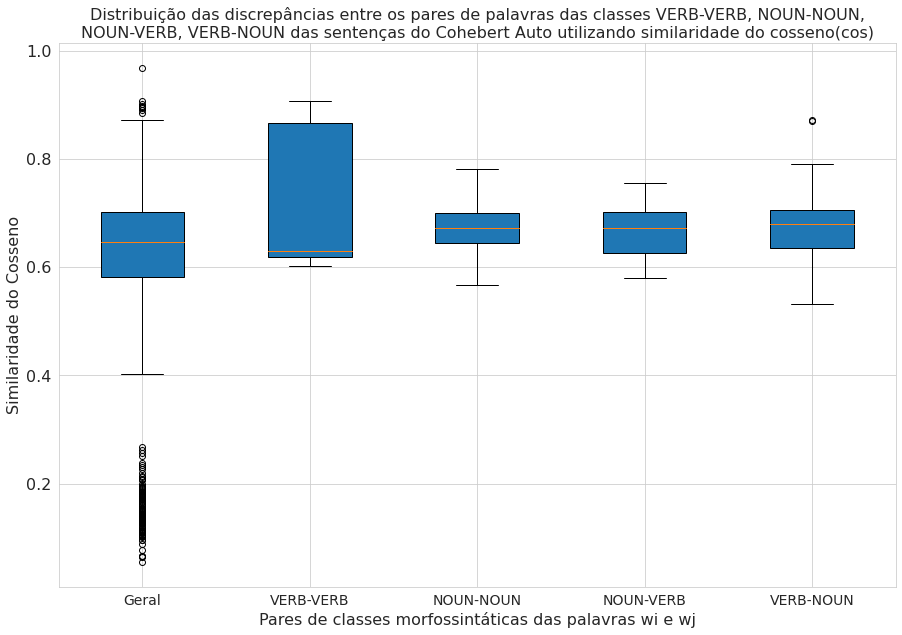

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_palavra[["cos_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_mean"]].dropna(),
           lista_comparacao_classesNV[["cos_mean"]].dropna(),
           lista_comparacao_classesVN[["cos_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["euc_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_mean"]].dropna(),
                    lista_comparacao_classesNV[["euc_mean"]].dropna(),
                    lista_comparacao_classesVN[["euc_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,euc_mean,euc_mean,euc_mean,euc_mean,euc_mean
count,2240.000000,16.000000,106.000000,34.000000,90.000000
mean,33.349606,27.834528,34.073814,31.827191,32.309340
std,5.305865,8.689005,4.699264,4.103805,5.128457
min,6.765657,15.100810,23.661400,25.232309,17.615896
25%,29.716749,18.348279,31.360667,28.993565,29.683391
50%,33.041214,32.585564,33.363808,32.325972,31.907059
75%,36.629876,34.201131,35.736831,34.510322,34.684297
max,50.941257,36.627090,47.091286,39.462299,47.674778


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


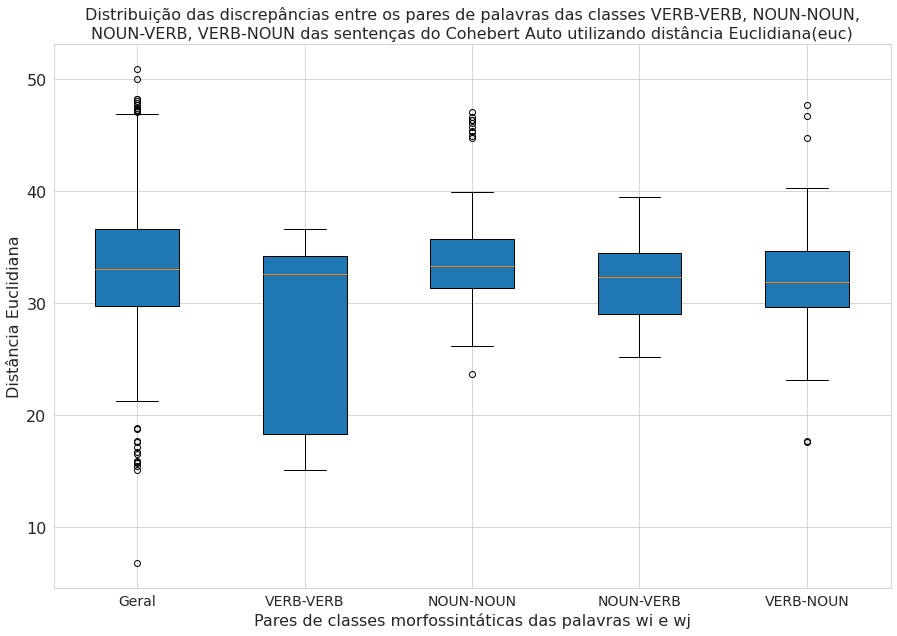

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_palavra[["euc_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_mean"]].dropna(),
           lista_comparacao_classesNV[["euc_mean"]].dropna(),
           lista_comparacao_classesVN[["euc_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

#### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_palavra[["man_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_mean"]].dropna(),
                    lista_comparacao_classesNV[["man_mean"]].dropna(),
                    lista_comparacao_classesVN[["man_mean"]].dropna()
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

df_all.describe(include=["float", "int"]) 

,Geral,VERB-VERB,NOUN-NOUN,NOUN-VERB,VERB-NOUN
,man_mean,man_mean,man_mean,man_mean,man_mean
count,2240.000000,16.000000,106.000000,34.000000,90.000000
mean,1592.330062,1336.068399,1560.736746,1512.432874,1510.593460
std,212.915325,408.509942,132.027556,189.933855,204.732509
min,166.194550,729.162960,1134.934800,1214.173800,848.396240
25%,1456.323950,884.734590,1473.984000,1344.560325,1411.456275
50%,1607.303550,1573.795550,1540.791250,1530.428550,1519.587600
75%,1730.974200,1644.281225,1671.023925,1661.190575,1619.585175
max,2187.814500,1741.616300,1861.107300,1840.356900,1884.903900


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


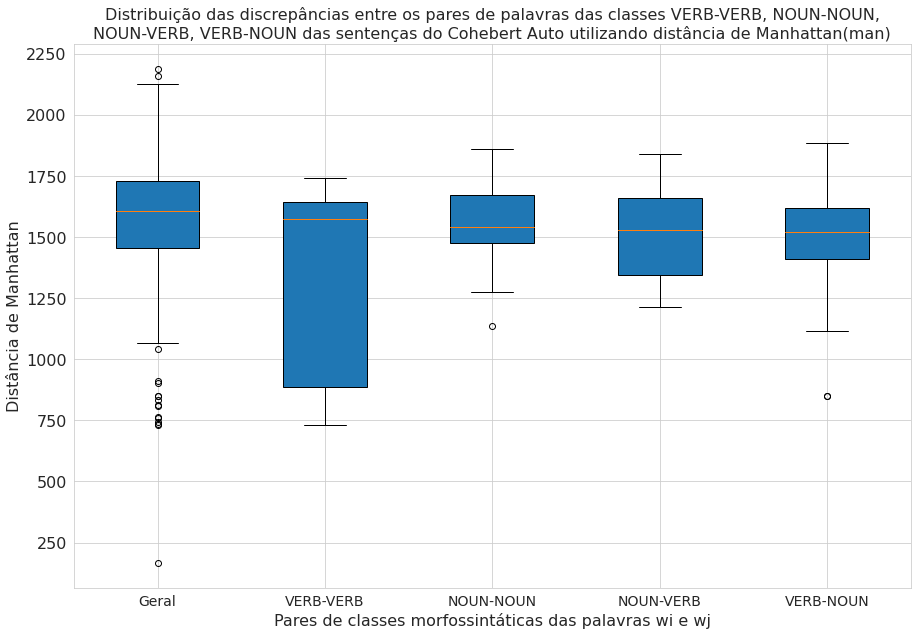

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre os pares de palavras das classes VERB-VERB, NOUN-NOUN,\nNOUN-VERB, VERB-NOUN das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintáticas das palavras wi e wj")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_palavra[["man_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_mean"]].dropna(),
           lista_comparacao_classesNV[["man_mean"]].dropna(),
           lista_comparacao_classesVN[["man_mean"]].dropna()
           ]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3, 4, 5], ["Geral", "VERB-VERB", "NOUN-NOUN","NOUN-VERB", "VERB-NOUN"])

plt.show()

## 3.6 Ocorrências de pares de palavras

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_palavra_indexado = lista_comparacao_palavra.set_index(["id"])
lista_comparacao_palavra_indexado.head()

,index_documento,index_sentenca,index_wi,wi,pos_i,index_wj,wj,pos_j,cos_mean,euc_mean,man_mean,cos_max,euc_max,man_max
id,,,,,,,,,,,,,,
1,0,0,0,Como,SCONJ,1,enfileirar,VERB,0.759586,25.941952,1294.481300,0.673417,31.297092,1554.191700
1,0,0,0,Como,SCONJ,2,elementos,NOUN,0.607320,37.124222,1770.785400,0.607320,37.124222,1770.785400
1,0,0,0,Como,SCONJ,3,em,ADP,0.658418,33.079350,1641.086400,0.658418,33.079350,1641.086400
1,0,0,0,Como,SCONJ,4,uma,DET,0.700411,29.079645,1441.169700,0.700411,29.079645,1441.169700
1,0,0,0,Como,SCONJ,5,fila,NOUN,0.630520,31.865469,1558.006500,0.578515,35.350060,1716.585000


### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos'

# Estratégia medida
estrategia_medida = 'mean'

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]

          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1

          # Acumula medida
          soma_medida = soma_medida +  linha[medida + '_' + estrategia_medida]
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3
                                                    linha['cos_mean'],  # 4
                                                    linha['euc_mean'],  # 5
                                                    linha['man_mean'],  # 6
                                                    linha['cos_max'],   # 7
                                                    linha['euc_max'],   # 8
                                                    linha['man_max'],   # 9                                                    
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)
media = soma_medida / conta
print("Média medida", (medida + "_" + estrategia_medida), " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  197
Média medida cos_mean  :  0.5993507415963913


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[4] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") " + linha2[2] + "(" + linha2[3] + ")"

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de pares de palavras com similaridade acima do threshold

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):

  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de pares de palavras com similaridade do cosseno acima do threshold
1 pilha(NOUN) ?(PUNCT) 20
2 pilha(NOUN) uma(DET) 20
3 pilha(NOUN) elementos(NOUN) 12
4 pilha(NOUN) em(ADP) 12
5 pilha(NOUN) empilhar(VERB) 9
6 pilha(NOUN) e(CCONJ) 8
7 pilha(NOUN) é(AUX) 7
8 pilha(NOUN) Como(SCONJ) 6
9 pilha(NOUN) enfileirar(VERB) 6
10 pilha(NOUN) como(ADV) 6
11 pilha(NOUN) elemento(NOUN) 6
12 pilha(NOUN) O(PRON) 5
13 pilha(NOUN) desempilhar(NOUN) 4
14 pilha(NOUN) um(DET) 4
15 pilha(NOUN) nela(PRON) 4
16 pilha(NOUN) de(SCONJ) 4
17 pilha(NOUN) desempilhar(VERB) 3
18 pilha(NOUN) estrutura(NOUN) 3
19 pilha(NOUN) de(ADP) 3
20 pilha(NOUN) dados(NOUN) 3


### 3.6.2 Raio de proximidade

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Palavra a ser procurada
palavra_chave = "pilha"

# Constroi uma lista com as palavras próximas
lista_proximidade_chave = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações com a palavra chave
    lista_proximidade_chave_documento = []

    # Localiza as comparações de um documento
    lista_comp = lista_comparacao_palavra_indexado.loc[linha1['id']]
    
    # Analisa as palavras após a chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wi é igual a chave
        if linha['wi'].lower() == palavra_chave.lower():
          # Conta o número de comparações
          conta = conta + 1

          # Calcula a distância da chaves 
          distancia = abs(linha['index_wj'] - linha['index_wi'])
            
          # Guarda os dados da comparação          
          lista_proximidade_chave_documento.append([linha['wi'],        # 0
                                                    linha['pos_i'],     # 1
                                                    linha['wj'],        # 2
                                                    linha['pos_j'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])

    # Analisa as palavras antes dda chave
    for i, linha in lista_comp.iterrows():
      
        # Verifica se a palavra wj é igual a chave
        if linha['wj'].lower() == palavra_chave.lower():          
          # Conta o número de comparações
          conta = conta + 1
          
          # Calcula a distância da chaves 
          distancia = abs(linha['index_wi'] - linha['index_wj'])
          
          # Guarda os dados da comparação
          lista_proximidade_chave_documento.append([linha['wj'],        # 0
                                                    linha['pos_j'],     # 1
                                                    linha['wi'],        # 2
                                                    linha['pos_i'],     # 3                                                    
                                                    distancia,          # 4
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade_chave.append([linha1['id'], lista_proximidade_chave_documento])

print("Número de comparações com ", palavra_chave, " : ", conta)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações com  pilha  :  197


#### 3.6.2.2 Seleciona comparações entre palavras que esteja a um determinado raio ao redor da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
raio = 2

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_chave_bar = tqdm_notebook(enumerate(lista_proximidade_chave), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade_chave))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_chave_bar:
  # if i < 5:

    # Verifica se existe comparações com a chave no documento
    if len(linha1[1]) != 0:

      # Percorre as comparações com a palavra chave no documento
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do raio
        if linha2[4] <= raio:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") - " + str(linha2[4]) + " - " + linha2[2] + "(" + linha2[3] + ")"
            
            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista ordenada das 20 maiores ocorrências de pares de palavras até o raio

In [ ]:
top = 20

print("Lista ordenada das", top, "maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das 20 maiores ocorrências de pares de palavras contendo a palavra chave com proximidade até o raio
1 pilha(NOUN) - 1 - uma(DET) 17
2 pilha(NOUN) - 1 - ?(PUNCT) 10
3 pilha(NOUN) - 1 - e(CCONJ) 8
4 pilha(NOUN) - 2 - é(AUX) 8
5 pilha(NOUN) - 2 - em(ADP) 7
6 pilha(NOUN) - 2 - como(ADV) 6
7 pilha(NOUN) - 2 - de(ADP) 3
8 pilha(NOUN) - 1 - dados(NOUN) 3
9 pilha(NOUN) - 2 - como(SCONJ) 2
10 pilha(NOUN) - 1 - a(DET) 2
11 pilha(NOUN) - 2 - operação(NOUN) 2
12 pilha(NOUN) - 2 - Em(ADP) 2


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:00:51 (h:mm:ss)
